In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [11]:
# info includes the `encoder`
encoder = info.features['text'].encoder

## Prepare the data for training

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None, ], []))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None, ], []))

## Create the model

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # output shape is 128 = 64 + 64, i.e. 1st timestamp + last timestamp
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.fit(train_dataset,
          epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
391/391 [==============================] - 40s 103ms/step - loss: 0.4906 - accuracy: 0.7247 - val_loss: 0.3694 - val_accuracy: 0.8484
Epoch 2/10
391/391 [==============================] - 39s 100ms/step - loss: 0.2885 - accuracy: 0.8828 - val_loss: 0.3552 - val_accuracy: 0.8708
Epoch 3/10
391/391 [==============================] - 39s 100ms/step - loss: 0.2327 - accuracy: 0.9114 - val_loss: 0.3299 - val_accuracy: 0.8656
Epoch 4/10
391/391 [==============================] - 39s 101ms/step - loss: 0.2022 - accuracy: 0.9248 - val_loss: 0.3254 - val_accuracy: 0.8620
Epoch 5/10
391/391 [==============================] - 39s 101ms/step - loss: 0.1771 - accuracy: 0.9358 - val_loss: 0.3513 - val_accuracy: 0.8687
Epoch 6/10
391/391 [==============================] - 39s 101ms/step - loss: 0.1567 - accuracy: 0.9454 - val_loss: 0.4019 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 39s 100ms/step - loss: 0.1444 - accuracy: 0.9510 - val_loss: 0.3662 - val_ac

In [43]:
import tensorflow_docs as docs
from tensorflow_docs import plots
import matplotlib.pyplot as plt

In [19]:
plotter = docs.plots.HistoryPlotter()

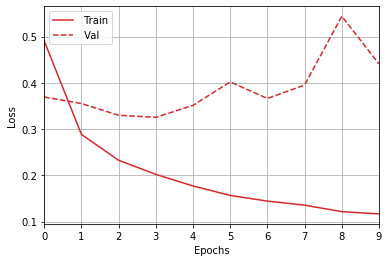

In [47]:
plotter.plot({'': model.history}, metric='loss')

(0.0, 1.0)

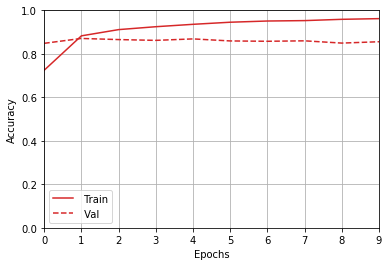

In [49]:
plotter.plot({'': model.history}, metric='accuracy')
plt.ylim([0, 1])

## Stack two or more LSTM layers

In [52]:
model_stack = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # output [BATCH, timesteps, 64+64]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # output [BATCH, 32+32]
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [54]:
model_stack.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

In [55]:
model_stack.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [56]:
model_stack.fit(train_dataset,
                epochs=10,
                validation_data=test_dataset,
                validation_steps=30)

Epoch 1/10
391/391 [==============================] - 71s 181ms/step - loss: 0.6679 - accuracy: 0.5370 - val_loss: 0.5162 - val_accuracy: 0.7469
Epoch 2/10
391/391 [==============================] - 70s 178ms/step - loss: 0.3900 - accuracy: 0.8342 - val_loss: 0.3749 - val_accuracy: 0.8255
Epoch 3/10
391/391 [==============================] - 70s 180ms/step - loss: 0.2774 - accuracy: 0.8966 - val_loss: 0.3357 - val_accuracy: 0.8641
Epoch 4/10
391/391 [==============================] - 70s 178ms/step - loss: 0.2211 - accuracy: 0.9231 - val_loss: 0.3429 - val_accuracy: 0.8698
Epoch 5/10
391/391 [==============================] - 70s 178ms/step - loss: 0.1895 - accuracy: 0.9375 - val_loss: 0.3728 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 70s 179ms/step - loss: 0.1647 - accuracy: 0.9476 - val_loss: 0.4084 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 70s 178ms/step - loss: 0.1455 - accuracy: 0.9554 - val_loss: 0.4142 - val_ac

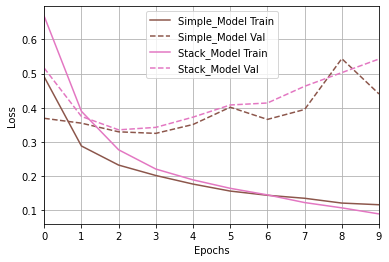

In [57]:
plotter.plot({'simple_model': model.history, 'stack_model': model_stack.history}, metric='loss')

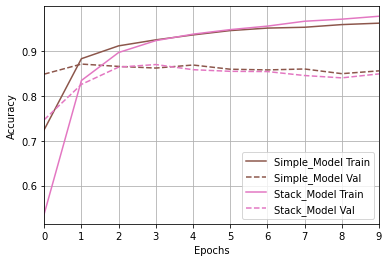

In [58]:
plotter.plot({'simple_model': model.history, 'stack_model': model_stack.history}, metric='accuracy')